In [1]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
from tensorflow.keras.datasets import imdb
import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

# 전처리 및 데이터 분리

In [3]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # 결과를 저장할 0 행렬 생성
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 # 문장에 존재하는 단어들만 one-hot encoding
    return results

# 문장들을 일정한 크기의 벡터로 변환
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

# 리스트 형태인 레이블을 벡터로 변환
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

X_valid = X_train[:10000]
X_train = X_train[10000:]
y_valid = y_train[:10000]
y_train = y_train[10000:]

# 모델 학습(조기 종료 콜백함수 버전)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3),
                  ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(X_train, 
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_valid, y_valid),
                    callbacks = callbacks_list)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Using TensorFlow backend.


Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 196us/step - loss: 0.4494 - acc: 0.8174 - val_loss: 0.3169 - val_acc: 0.8835
Epoch 2/20
15000/15000 [==============================] - 2s 153us/step - loss: 0.2389 - acc: 0.9174 - val_loss: 0.2760 - val_acc: 0.8907
Epoch 3/20
15000/15000 [==============================] - 2s 150us/step - loss: 0.1709 - acc: 0.9395 - val_loss: 0.2794 - val_acc: 0.8893
Epoch 4/20
15000/15000 [==============================] - 2s 152us/step - loss: 0.1306 - acc: 0.9549 - val_loss: 0.3578 - val_acc: 0.8651
Epoch 5/20
15000/15000 [==============================] - 2s 154us/step - loss: 0.1007 - acc: 0.9670 - val_loss: 0.3349 - val_acc: 0.8790


# 학습 과정 확인

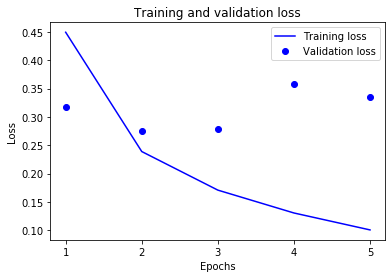

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss') # 'b'는 파란색 실선을 의미
plt.plot(epochs, val_loss, 'bo', label='Validation loss') # 'bo'는 파란색 점을 의미
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

# 최적 모델 불러오기

In [6]:
from keras.models import load_model

model = load_model('model.h5')
print('>> model load!!')

>> model load!!


# 성능 평가

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

25000/25000 [==============================] - 3s 133us/step
test loss:  0.2915469863796234
test acc:  0.8834
